In [1]:
from matplotlib import pyplot as plt
import platform, os, sys, time, scipy
import numpy as np
from tabulate import tabulate
from pprint import pprint
from importlib import reload
from ipywidgets import interact, interact_manual
from scipy.optimize import minimize, approx_fprime
from termcolor import colored, cprint
from scipy.interpolate import RectBivariateSpline

if 'Windows' in platform.system():
    sys.path.append(r'C:\Users\slab\Documents\Code')
    sys.path.append(r'D:\BEMPP_shared\Modules')
    import interpolate_slow
else:
    sys.path.append("/Users/gkoolstra/Documents/Code")
    from BEMHelper import interpolate_slow
    
from Common import common, kfit
from TrapAnalysis import trap_analysis, import_data, artificial_anneal as anneal
from mpl_toolkits.mplot3d import Axes3D

%matplotlib inline
%config InlineBackend.figure_format='retina'

Could not import BEM module. Please do so manually.


In [2]:
%%javascript
$.getScript('https://kmahelona.github.io/ipython_notebook_goodies/ipython_notebook_toc.js')

<IPython.core.display.Javascript object>

<h1 id="tocheading">Table of Contents</h1>
<div id="toc"></div>

# Import potential data

Resonator data was replaced from x = 4.34 um to x = 9.50 um


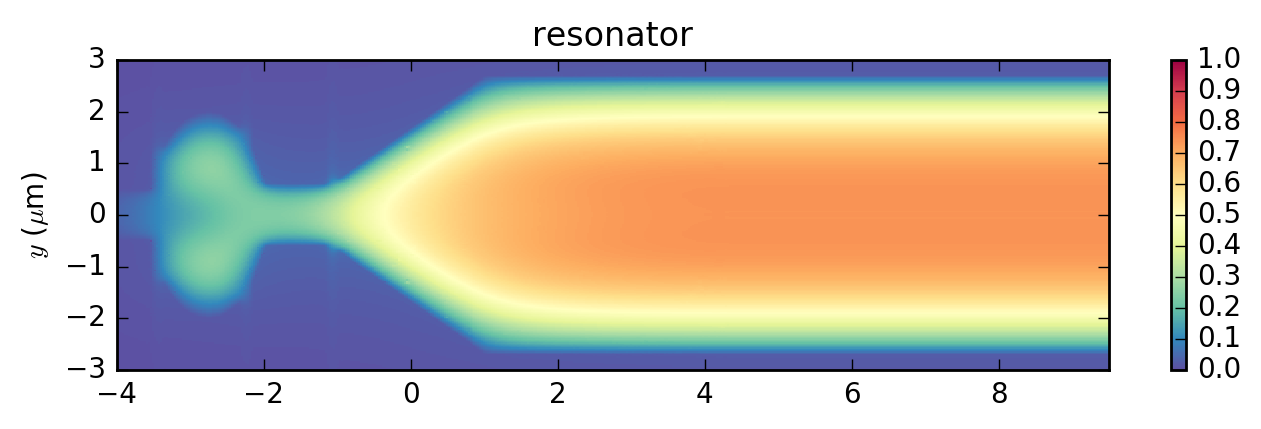

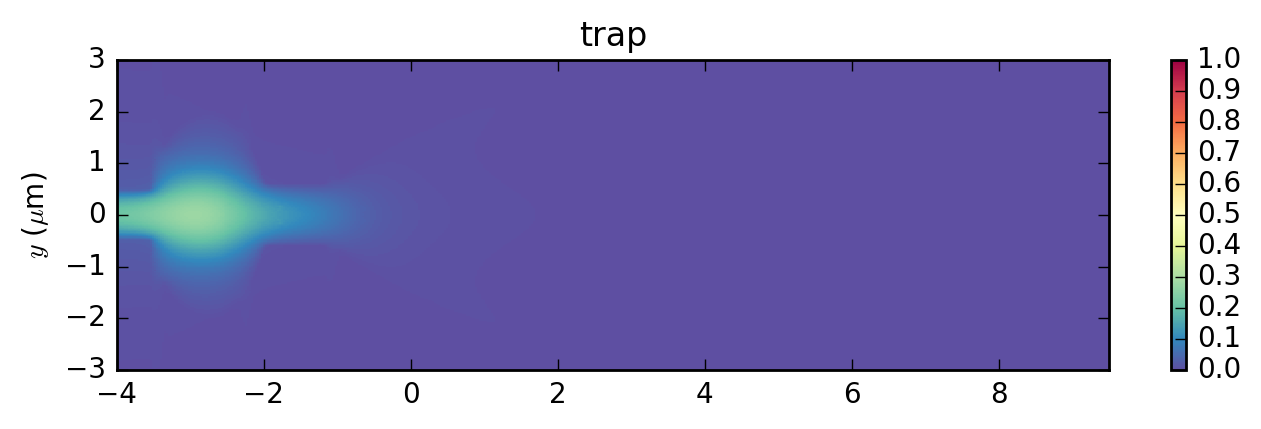

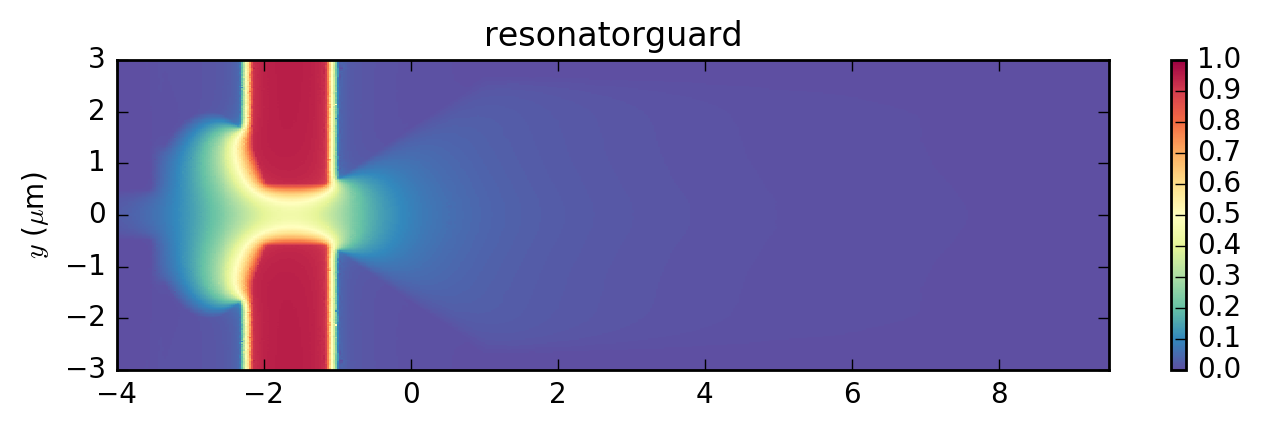

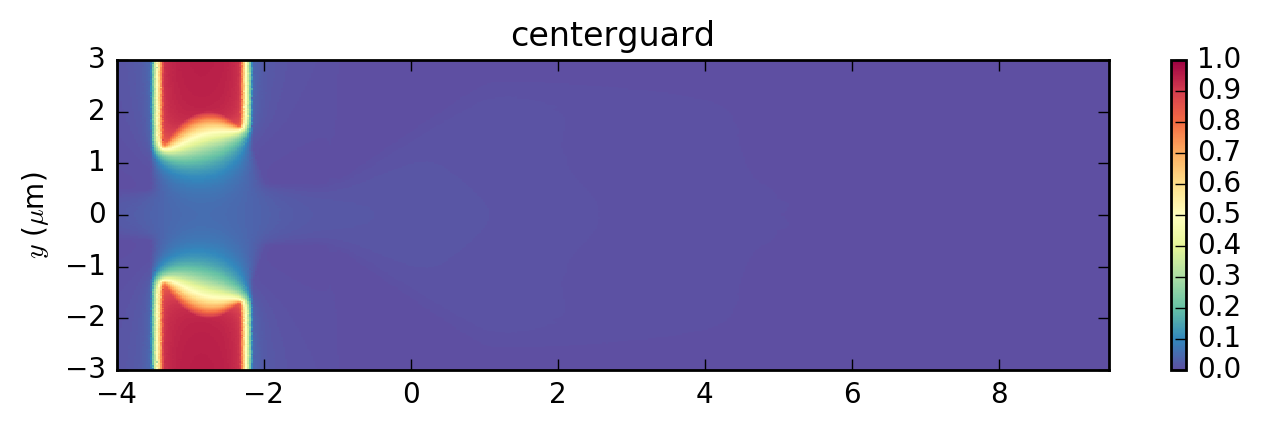

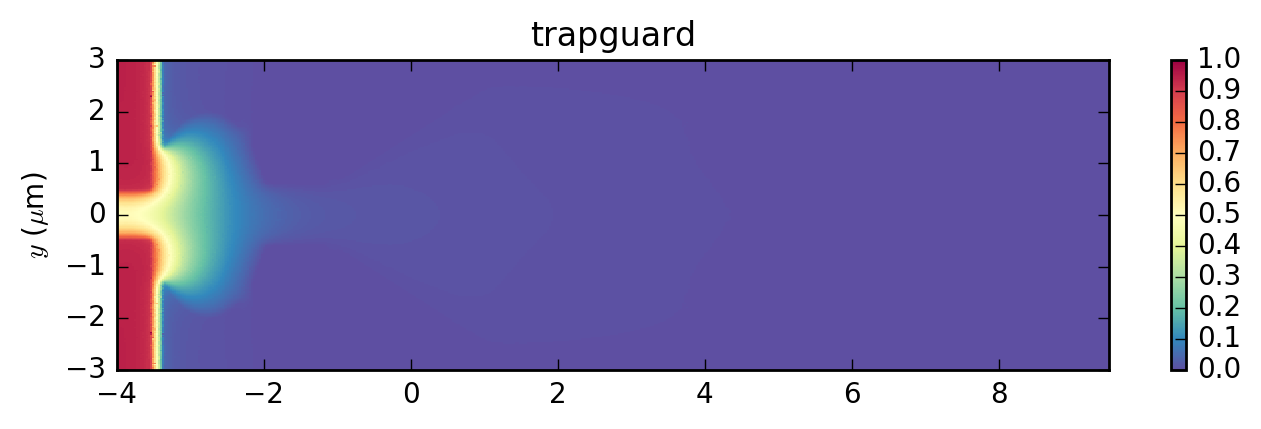

In [3]:
# Evaluate all files in the range. 
xeval=np.linspace(-4, 9.5, 501)

# Do not evaluate the files on the simulation boundary, this gives errors.
# Here I construct an array from y0 to -dy/2, with spacing dy. This limits
# our choice for y-points because, the spacing must be such that there's 
# an integer number of points in yeval. This can only be the case if 
# dy = 2 * ymin / (2*k+1) and Ny = ymin / dy - 0.5 + 1
# yeval = y0, y0 - dy, ... , -3dy/2, -dy/2

y0 = -3.0 # Starting point for y
k = 121 # This defines the sampling
dy = 2*np.abs(y0)/np.float(2*k+1) 
yeval = np.linspace(y0, -dy/2., (np.abs(y0)-0.5*dy)/dy + 1)

master_path = r"/Users/gkoolstra/Desktop/Electron optimization/Realistic potential/Potentials/V6 - Greater Trap Area"

datafiles = ["Resonator.dsp",
             "Trap.dsp",
             "ResonatorGuard.dsp",
             "CenterGuard.dsp", 
             "TrapGuard.dsp"]

output = list()
names = ['resonator', 'trap', 'resonatorguard', 'centerguard', 'trapguard']
plt.figure(figsize=(9.,12.))
idx = 1

for name, datafile in zip(names, datafiles):
    elements, nodes, elem_solution, bounding_box = trap_analysis.load_dsp(os.path.join(master_path, datafile))
    xdata, ydata, Udata = interpolate_slow.prepare_for_interpolation(elements, nodes, elem_solution)
    xcenter = np.mean(bounding_box[0:2])
    yedge = bounding_box[3]
    xdata -= xcenter
    ydata -= yedge
    xinterp, yinterp, Uinterp = interpolate_slow.evaluate_on_grid(xdata, ydata, Udata, xeval=xeval, yeval=yeval, 
                                                                  clim=(0, 1.0), plot_axes='xy', 
                                                                  cmap=plt.cm.Spectral_r, plot_mesh=False, 
                                                                  plot_data=False)
    
    # Mirror around the y-axis
    ysize, xsize = np.shape(Uinterp)
    Uinterp_symmetric = np.zeros((2*ysize, xsize))
    Uinterp_symmetric[:ysize, :] = Uinterp
    Uinterp_symmetric[ysize:,:] = Uinterp[::-1,:]
    
    y_symmetric = np.zeros((2*ysize, xsize))
    y_symmetric[:ysize,:] = yinterp
    y_symmetric[ysize:,:] = -yinterp[::-1,:]
    
    x_symmetric = np.zeros((2*ysize, xsize))
    x_symmetric[:ysize,:] = xinterp
    x_symmetric[ysize:,:] = xinterp
    
    # Draw a imaginary line at the minimum of the resonator potential and
    # substitute the data to the right of that line with the minimum value
    if name == "resonator":
        res_left_idx = np.argmax(Uinterp_symmetric[common.find_nearest(y_symmetric[:,0], 0), :])  
        res_left_x = x_symmetric[0, res_left_idx]
        res_right_x = x_symmetric[0, -1]
        # Note: res_left_x and res_right_x are in units of um
        print("Resonator data was replaced from x = %.2f um to x = %.2f um"%(res_left_x, res_right_x))
        
        for i in range(res_left_idx, np.shape(Uinterp_symmetric)[1]):
            Uinterp_symmetric[:, i] = Uinterp_symmetric[:, res_left_idx]
    
    plt.figure(figsize=(8.,2.))
    plt.title(name)
    plt.pcolormesh(x_symmetric, y_symmetric, Uinterp_symmetric, cmap=plt.cm.Spectral_r, vmin=0.0, vmax=1.0)
    plt.colorbar()
    plt.xlim(np.min(x_symmetric), np.max(x_symmetric))
    plt.ylim(np.min(y_symmetric), np.max(y_symmetric))
    plt.ylabel("$y$ ($\mu$m)")
    
    output.append({'name' : name, 'V' : np.array(Uinterp_symmetric.T, dtype=np.float64),
                   'x' : np.array(x_symmetric.T, dtype=np.float64), 
                   'y' : np.array(y_symmetric.T, dtype=np.float64)})
    
    idx += 1
    
yeval = np.append(yeval, -yeval[::-1])

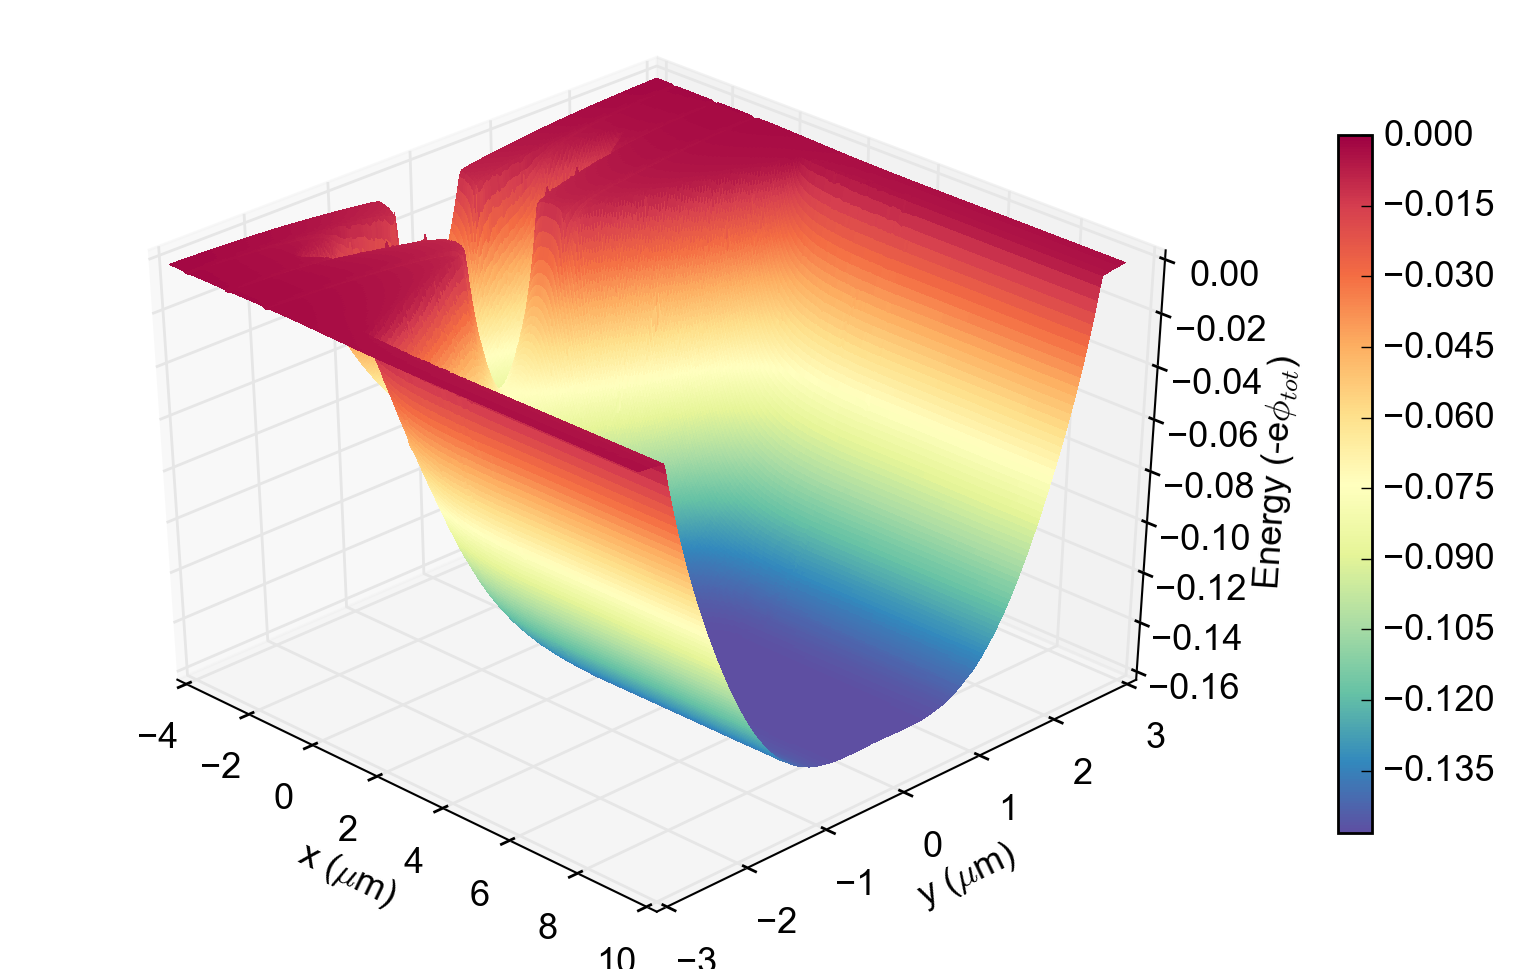

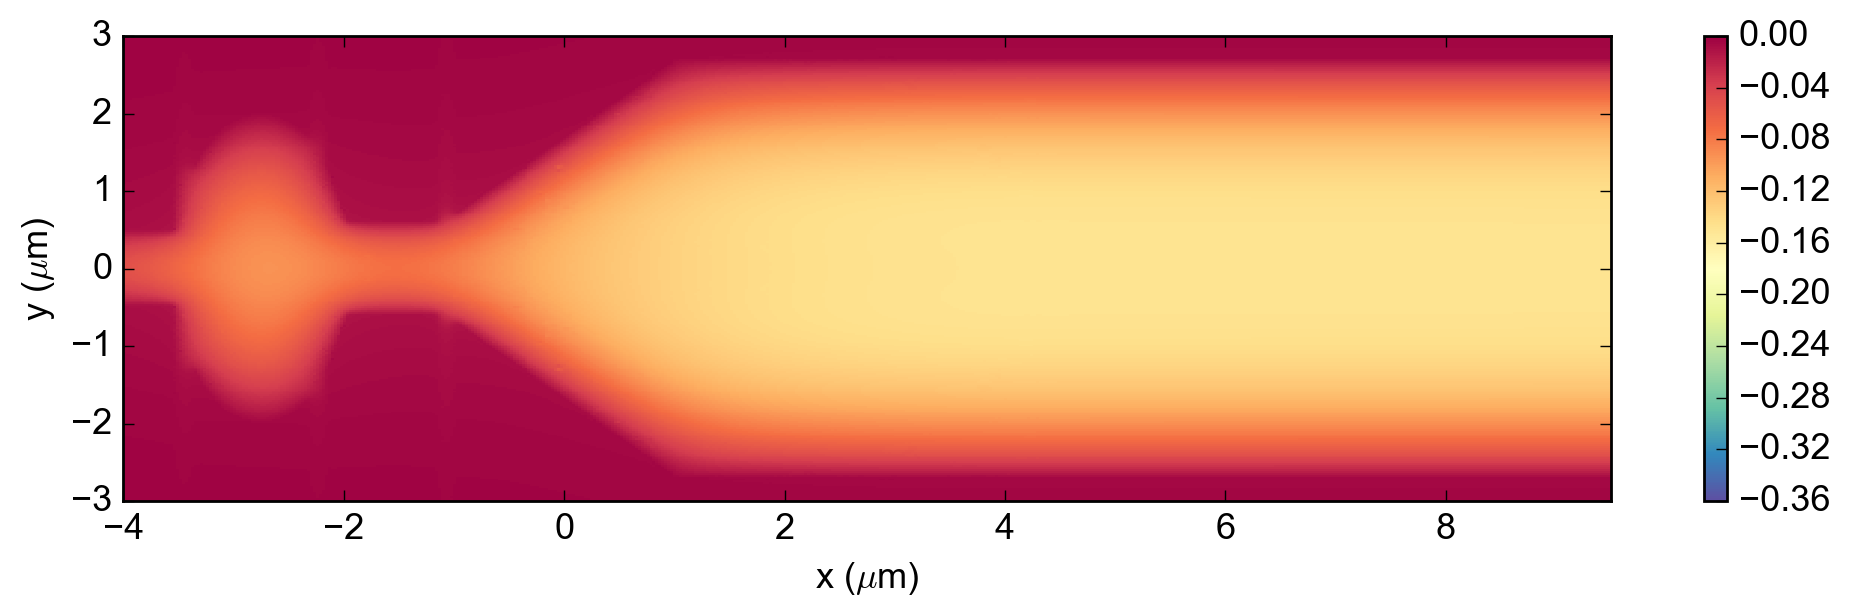

In [4]:
t = trap_analysis.TrapSolver()
c = trap_analysis.get_constants()

Vres = 0.20
Vtrap = 0.20
Vrg = 0.00
Vcg = 0.0
Vtg = -0.00

xeval, yeval, cropped_potentials = t.crop_potentials(output, ydomain=None, xdomain=None)
coefficients = np.array([Vres, Vtrap, Vrg, Vcg, Vtg])
combined_potential = t.get_combined_potential(cropped_potentials, coefficients)

Xm, Ym = np.meshgrid(xeval, yeval)

for view_angle in [-45]:
    fig = plt.figure(figsize=(10.,6.))
    common.configure_axes(13)
    ax = fig.gca(projection='3d')
    surf = ax.plot_surface(Xm, Ym, -combined_potential, rstride=1, cstride=1, cmap=plt.cm.Spectral_r,
                           linewidth=0, antialiased=False, vmax=0.0)
    ax.set_xlabel("x ($\mu$m)")
    ax.set_ylabel("y ($\mu$m)")
    ax.set_zlabel("Energy (-e$\phi_{tot}$)")
    ax.view_init(elev=35., azim=view_angle)
    fig.colorbar(surf, shrink=0.75, aspect=20)  
    
fig = plt.figure(figsize=(12.,3.))
common.configure_axes(13)
plt.pcolormesh(Xm, Ym, -combined_potential, cmap=plt.cm.Spectral_r, vmax=0.0, vmin=-0.36)
plt.xlabel("x ($\mu$m)")
plt.ylabel("y ($\mu$m)")
plt.xlim(np.min(xeval), np.max(xeval))
plt.ylim(np.min(yeval), np.max(yeval))
plt.colorbar()

In [98]:
class FullSolver:

    def __init__(self, grid_data_x, grid_data_y, potential_data, resonator_domain, 
                 spline_order_x=3, spline_order_y=3, smoothing=0):
        """
        This class is used for constructing the functional forms required for scipy.optimize.minimize.
        It deals with the Maxwell input data, as well as constructs the cost function used in the optimizer.
        It also calculates the gradient, that can be used to speed up the optimizer.
        :param grid_data_x: 1D array of x-data. Coordinates from grid_data_x & grid_data_y must form a rectangular grid
        :param grid_data_y: 1D array of y-data. Coordinates from grid_data_x & grid_data_y must form a rectangular grid
        :param potential_data: Energy land scape, - e V_ext.
        :param spline_order_x: Order of the interpolation in the x-direction (1 = linear, 3 = cubic)
        :param spline_order_y: Order of the interpolation in the y-direction (1 = linear, 3 = cubic)
        :param smoothing: Absolute smoothing. Effect depends on scale of potential_data.
        """
        self.interpolator = RectBivariateSpline(grid_data_x, grid_data_y, potential_data,
                                                kx=spline_order_x, ky=spline_order_y, s=smoothing)

        # Constants
        self.qe = 1.602E-19
        self.eps0 = 8.85E-12
        
        self.res_left_x, self.res_right_x = resonator_domain
        self.res_center = (self.res_left_x + self.res_right_x)/2.0

    def V(self, xi, yi):
        """
        Evaluate the electrostatic potential at coordinates xi, yi
        :param xi: a 1D array, or float
        :param yi: a 1D array or float
        :return: Interpolated value(s) of the data supplied to __init__ at values (xi, yi)
        """
        return self.interpolator.ev(xi, yi)

    def Velectrostatic(self, xi, yi):
        """
        When supplying two arrays of size n to V, it returns an array
        of size nxn, according to the meshgrid it has evaluated. We're only interested
        in the sum of the diagonal elements, so we take the sum and this represents
        the sum of the static energy of the n particles in the potential.
        :param xi: a 1D array, or float
        :param yi: a 1D array or float
        """
        xi = self.map_x_into_domain(xi, resonator_bounds=(self.res_left_x, self.res_right_x))
        return self.qe * np.sum(self.V(xi, yi))

    def Vee(self, xi, yi, eps=1E-15):
        """
        Returns the repulsion potential between two electrons separated by a distance sqrt(|xi-xj|**2 + |yi-yj|**2)
        Note the factor 1/2. in front of the potential energy to avoid overcounting. 
        :param xi: a 1D array, or float
        :param yi: a 1D array or float
        """ 
        xi = self.map_x_into_domain(xi, resonator_bounds=(self.res_left_x, self.res_right_x))
        XiXj, YiYj, Rij = self.calculate_metrics(xi, yi)
        np.fill_diagonal(Rij, eps)
        return + 1 / 2. * self.qe ** 2 / (4 * np.pi * self.eps0) * 1 / Rij

    def Vtotal(self, r):
        """
        This can be used as a cost function for the optimizer.
        Returns the total energy of N electrons
        r is a 0D array with coordinates of the electrons.
        The x-coordinates are thus given by the even elements of r: r[::2],
        whereas the y-coordinates are the odd ones: r[1::2]
        :param r: r = np.array([x0, y0, x1, y1, x2, y2, ... , xN, yN])
        :return: Scalar with the total energy of the system.
        """
        xi, yi = r[::2], r[1::2]
        Vtot = self.Velectrostatic(xi, yi)
        interaction_matrix = self.Vee(xi, yi)
        np.fill_diagonal(interaction_matrix, 0)
        Vtot += np.sum(interaction_matrix)
        return Vtot / self.qe

    def dVdx(self, xi, yi):
        """
        Derivative of the electrostatic potential in the x-direction.
        :param xi: a 1D array, or float
        :param yi: a 1D array or float
        :return:
        """
        return self.interpolator.ev(xi, yi, dx=1, dy=0)

    def ddVdx(self, xi, yi):
        """
        Second derivative of the electrostatic potential in the x-direction.
        :param xi: a 1D array, or float
        :param yi: a 1D array or float
        :return:
        """
        return self.interpolator.ev(xi, yi, dx=2, dy=0)

    def dVdy(self, xi, yi):
        """
        Derivative of the electrostatic potential in the y-direction
        :param xi: a 1D array, or float
        :param yi: a 1D array or float
        :return:
        """
        return self.interpolator.ev(xi, yi, dx=0, dy=1)

    def ddVdy(self, xi, yi):
        """
        Second derivative of the electrostatic potential in the y-direction.
        :param xi: a 1D array, or float
        :param yi: a 1D array or float
        :return:
        """
        return self.interpolator.ev(xi, yi, dx=0, dy=2)

    def grad_Vee(self, xi, yi, eps=1E-15):
        """
        Derivative of the electron-electron interaction term
        :param xi: a 1D array, or float
        :param yi: a 1D array or float
        :param eps: A small but non-zero number to avoid triggering Warning message. Exact value is irrelevant.
        :return: 1D-array of size(xi) + size(yi)
        """
        # Resonator method
        xi = self.map_x_into_domain(xi, resonator_bounds=(self.res_left_x, self.res_right_x))
        XiXj, YiYj, Rij = self.calculate_metrics(xi, yi)
        np.fill_diagonal(Rij, eps)

        gradx_matrix = np.zeros(np.shape(Rij))
        grady_matrix = np.zeros(np.shape(Rij))
        gradient = np.zeros(2 * len(xi))
        
        gradx_matrix = -1 * self.qe ** 2 / (4 * np.pi * self.eps0) * (XiXj) / Rij ** 3
        np.fill_diagonal(gradx_matrix, 0)

        grady_matrix = +1 * self.qe ** 2 / (4 * np.pi * self.eps0) * (YiYj) / Rij ** 3
        np.fill_diagonal(grady_matrix, 0)

        gradient[::2] = np.sum(gradx_matrix, axis=0)
        gradient[1::2] = np.sum(grady_matrix, axis=0)

        return gradient

    def grad_total(self, r):
        """
        Total derivative of the cost function. This may be used in the optimizer to converge faster.
        :param r: r = np.array([x0, y0, x1, y1, x2, y2, ... , xN, yN])
        :return: 1D array of length len(r)
        """
        xi, yi = r[::2], r[1::2]
        gradient = np.zeros(len(r))
        gradient[::2] = self.dVdx(xi, yi)
        gradient[1::2] = self.dVdy(xi, yi)
        gradient += self.grad_Vee(xi, yi) / self.qe
        return gradient
    
    def calculate_metrics(self, xi, yi):
        Xi, Yi = np.meshgrid(xi, yi)
        Xj, Yj = Xi.T, Yi.T

        Rij = np.sqrt((Xi - Xj) ** 2 + (Yi - Yj) ** 2)

        Xi_shifted = Xi.copy()
        Xi_shifted[Xi_shifted < self.res_center] += (self.res_right_x-self.res_left_x)  # Shift entire box length
        Xj_shifted = Xi_shifted.T

        Rij_shifted = np.sqrt((Xi_shifted - Xj_shifted) ** 2 + (Yi - Yj) ** 2)
        
        # Use the shifted Rij only for electrons that lie in the region self.res_left_x < x < self.res_right_x
        # On top of that, only substitute it if that value is smaller.
        substitution_rule = np.logical_and(Rij_shifted<Rij, 
                                           np.logical_and(np.logical_and(Xi>EP.res_left_x, Xi<EP.res_right_x), 
                                                          np.logical_and(Xj>EP.res_left_x, Xj<EP.res_right_x)))
        
        np.copyto(Rij, Rij_shifted, where=substitution_rule)
        # We need the second pair of metrics for the gradient. 
        XiXj = (Xi - Xj)
        YiYj = Yi - Yj
        XiXj_shifted = (Xi_shifted - Xj_shifted)
        np.copyto(XiXj, XiXj_shifted, where=substitution_rule)
        
        return XiXj, YiYj, Rij
    
    def map_x_into_domain(self, x, resonator_bounds=None):
        mapped_x = x
        mapped_x[x>resonator_bounds[1]] = resonator_bounds[0] + (x[x>resonator_bounds[1]] - resonator_bounds[0]) \
        % (resonator_bounds[1] - resonator_bounds[0]) 
        return mapped_x

In [99]:
EP = FullSolver(xeval*1E-6, yeval*1E-6, -combined_potential.T, 
                resonator_domain=(res_left_x*1E-6, res_right_x*1E-6),
                spline_order_x=3, spline_order_y=3, smoothing=0.01)

[  1.00000000e-06   1.90909091e-06   2.81818182e-06   3.72727273e-06
   4.63636364e-06   5.54545455e-06   6.45454545e-06   7.36363636e-06
   8.27272727e-06   9.18181818e-06   1.00909091e-05   1.10000000e-05]


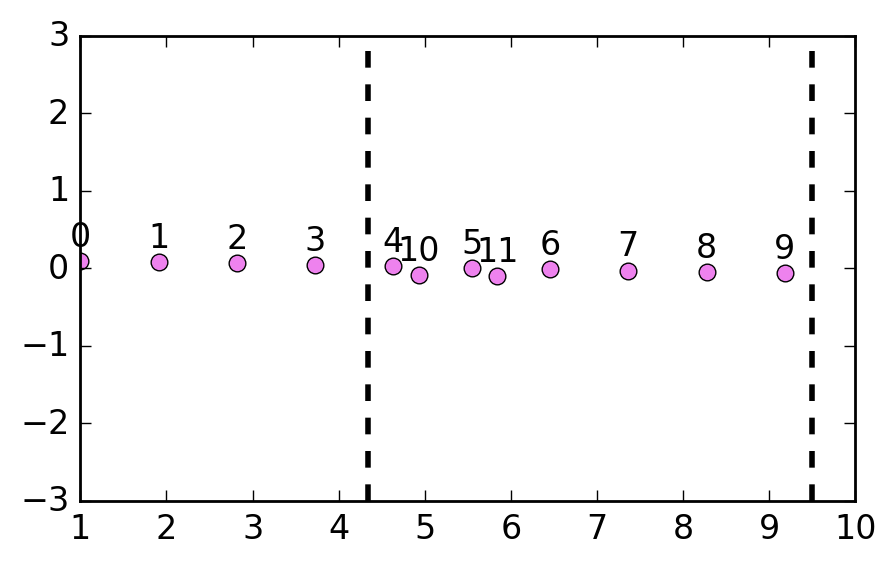

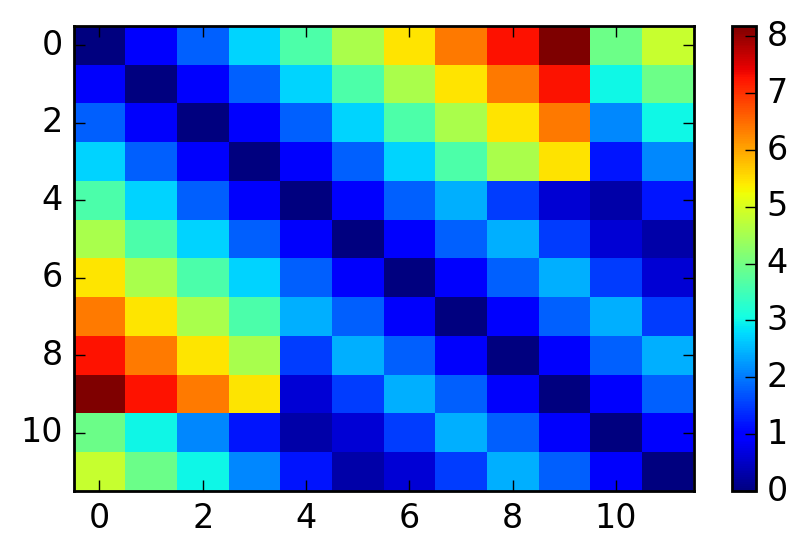

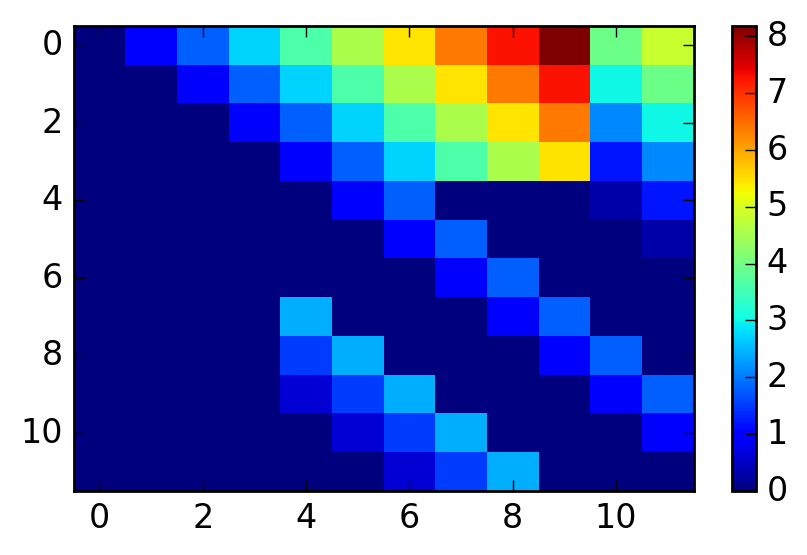

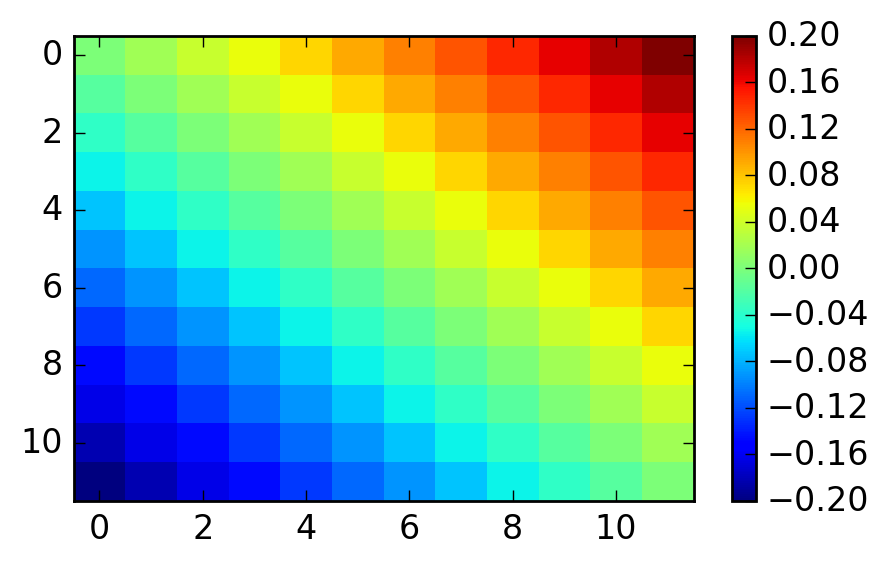

In [100]:
N = 12
xi = np.linspace(1.0, 11.0, N)*1E-6#np.array([1.0, 5.0, 4.0, 3.0, 6.0, 8.0, 9.0, 7.0, 2.0, 0.0, 10.0, 15.0])*1E-6 
yi = np.linspace(0.1E-6, -0.1E-6, N)

print(xi)

xi = EP.map_x_into_domain(xi, resonator_bounds=(EP.res_left_x, EP.res_right_x))
XiXj, YiYj, Rij = EP.calculate_metrics(xi, yi)

plt.figure(figsize=(5.,3.))
plt.plot(xi*1E6, yi*1E6, 'o', color='violet')
plt.vlines(res_right_x, -3.0, 3.0, linestyles='--', color='k', lw=2.0)
plt.vlines(res_left_x, -3.0, 3.0, linestyles='--', color='k', lw=2.0)
for k in range(N):
    plt.text(xi[k]*1E6, yi[k]*1E6 + 0.1, str(k), va='bottom', ha='center')

plt.figure(figsize=(5.,3.))
plt.imshow(Rij*1E6, interpolation='none', aspect='auto')
plt.colorbar()

plt.figure(figsize=(5.,3.))
plt.imshow(XiXj*1E6, interpolation='none', aspect='auto', vmin=0)
plt.colorbar()

plt.figure(figsize=(5.,3.))
plt.imshow(YiYj*1E6, interpolation='none', aspect='auto')
plt.colorbar()

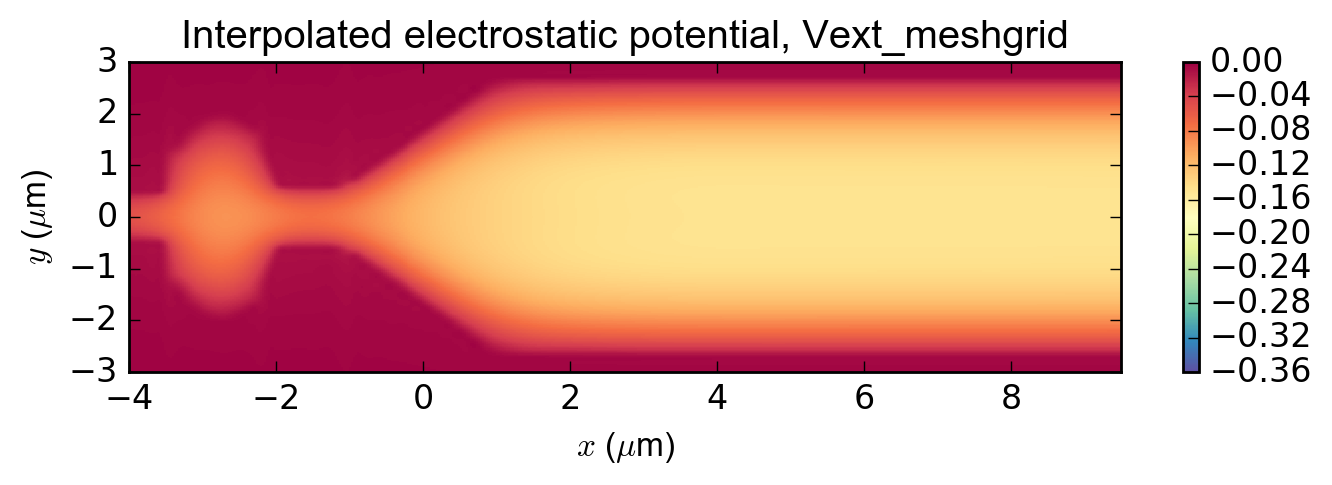

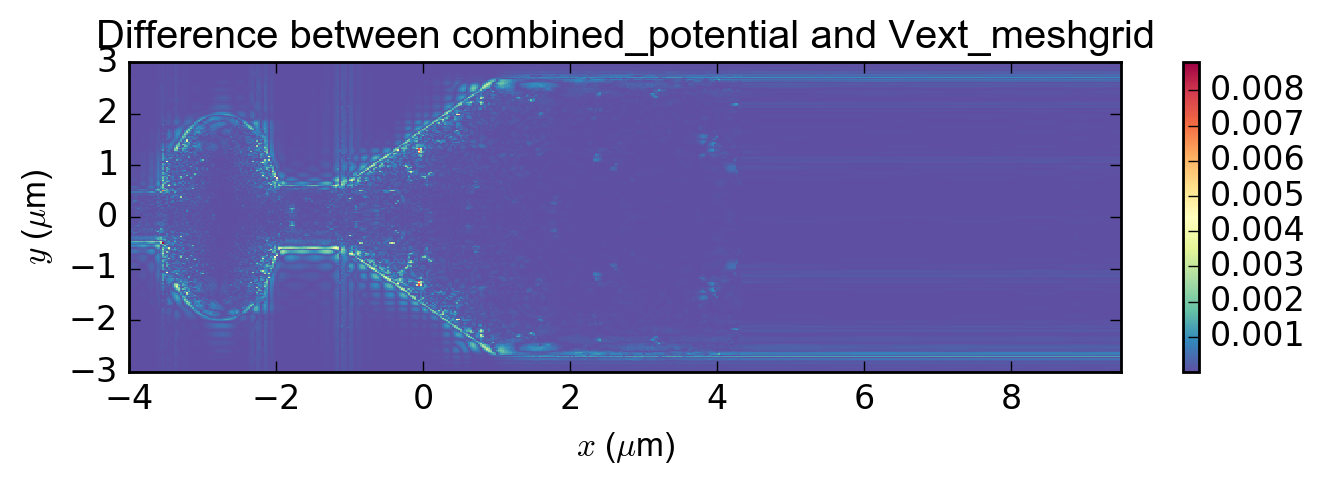

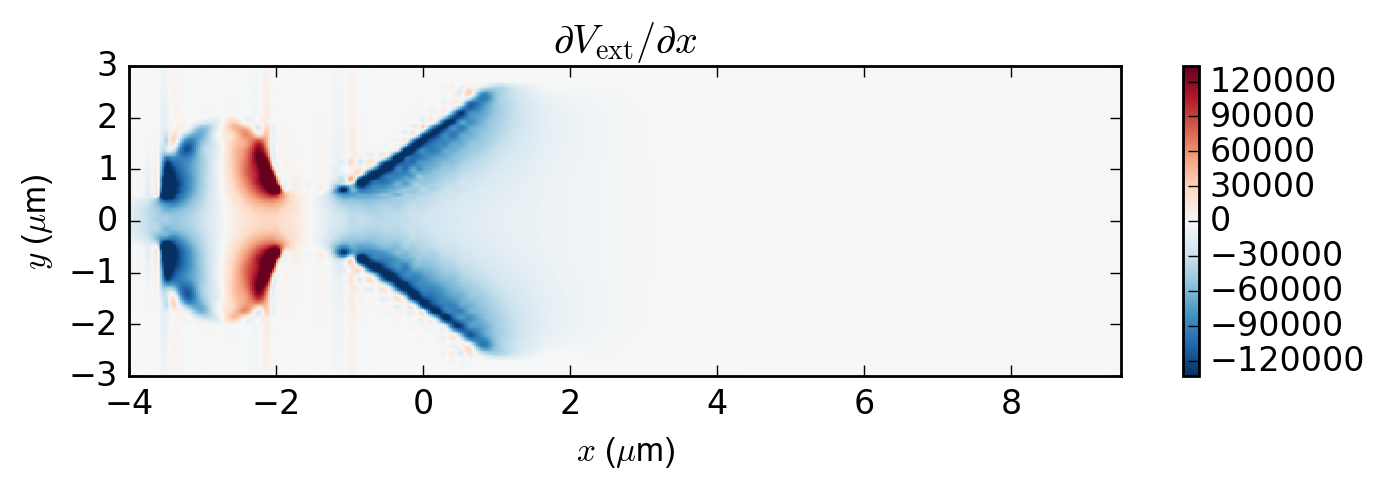

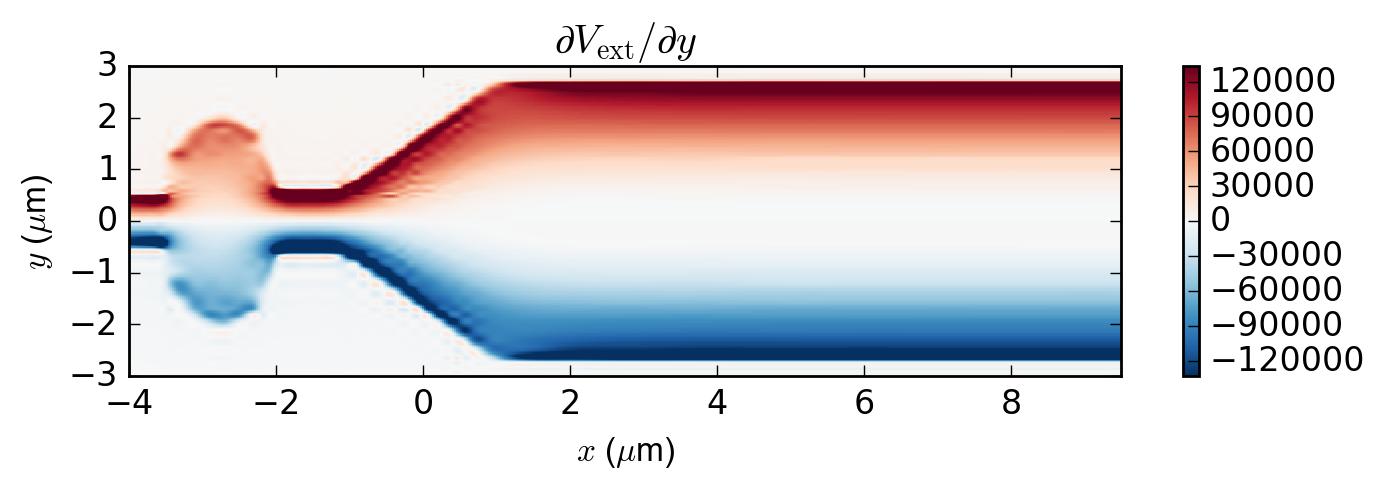

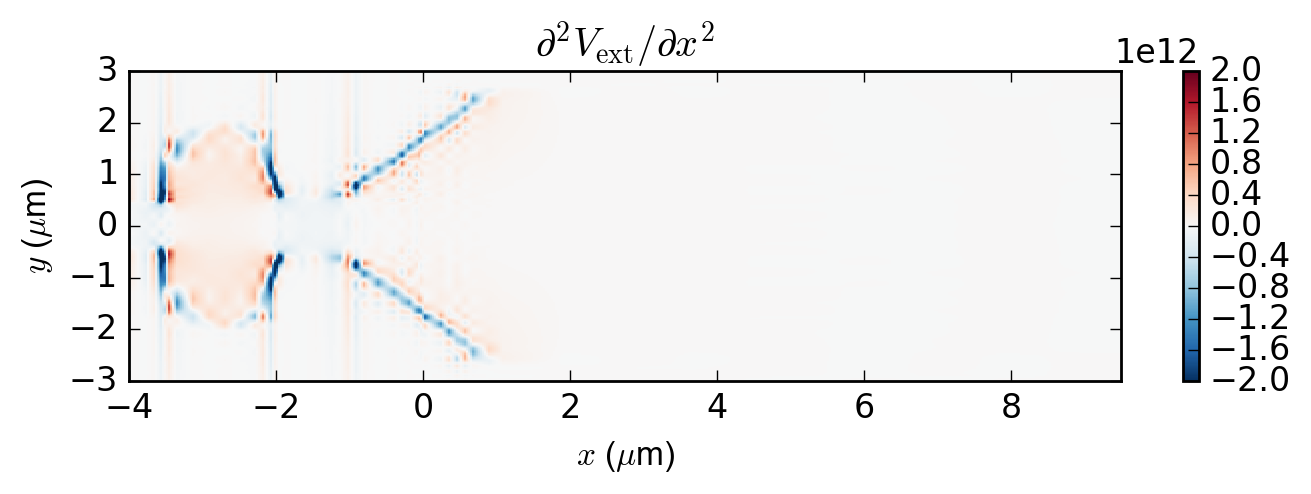

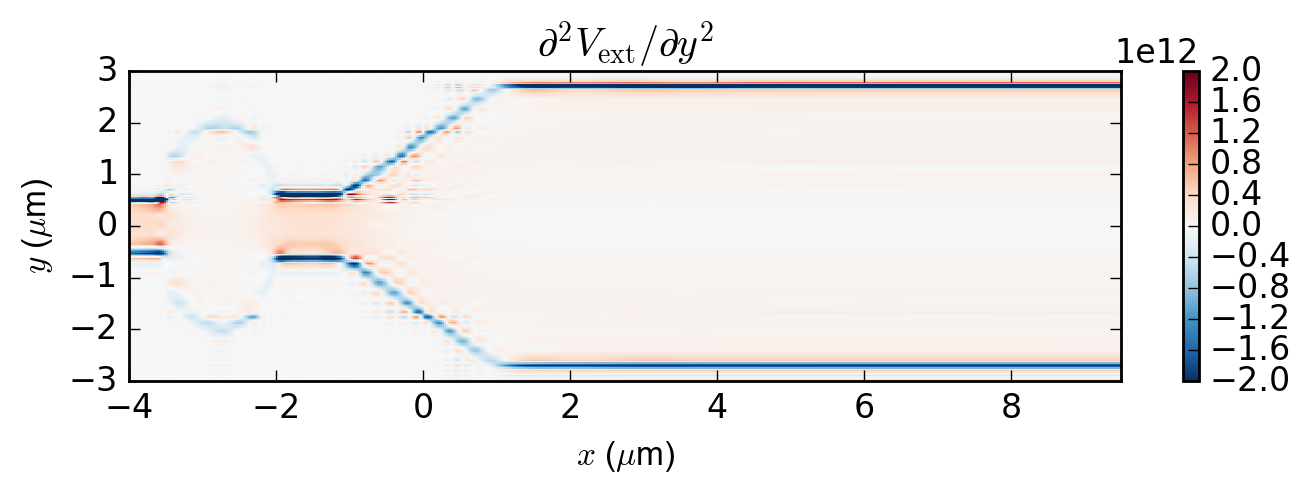

In [85]:
xtest = xeval*1E-6
ytest = yeval*1E-6
Xtest, Ytest = np.meshgrid(xtest, ytest)

plt.figure(figsize=(8.,2.))
plt.pcolormesh(Xtest*1E6, Ytest*1E6, EP.V(Xtest, Ytest), vmax=0.00, vmin=-0.36, cmap=plt.cm.Spectral_r)
plt.colorbar()
plt.xlim(np.min(xtest)*1E6, np.max(xtest)*1E6)
plt.ylim(np.min(ytest)*1E6, np.max(ytest)*1E6)
plt.title("Interpolated electrostatic potential, Vext_meshgrid")
plt.xlabel("$x$ ($\mu$m)")
plt.ylabel("$y$ ($\mu$m)")

if 1:
    plt.figure(figsize=(8.,2.))
    plt.pcolormesh(Xtest*1E6, Ytest*1E6, np.abs(EP.V(Xtest, Ytest)- (-combined_potential)), 
                   cmap=plt.cm.Spectral_r)
    plt.colorbar()
    plt.xlim(np.min(xtest)*1E6, np.max(xtest)*1E6)
    plt.ylim(np.min(ytest)*1E6, np.max(ytest)*1E6)
    plt.title(r"Difference between combined_potential and Vext_meshgrid")
    plt.xlabel("$x$ ($\mu$m)")
plt.ylabel("$y$ ($\mu$m)")

plt.figure(figsize=(8.,2.))
plt.pcolormesh(Xtest*1E6, Ytest*1E6, EP.dVdx(Xtest, Ytest), 
               cmap=plt.cm.RdBu_r, vmin=-1E5*Vres/0.15, vmax=1E5*Vres/0.15)
plt.colorbar()
plt.xlim(np.min(xtest)*1E6, np.max(xtest)*1E6)
plt.ylim(np.min(ytest)*1E6, np.max(ytest)*1E6)
plt.title(r"$\partial V_\mathrm{ext}/\partial x$")
plt.xlabel("$x$ ($\mu$m)")
plt.ylabel("$y$ ($\mu$m)")

plt.figure(figsize=(8.,2.))
plt.pcolormesh(Xtest*1E6, Ytest*1E6, EP.dVdy(Xtest, Ytest), 
               cmap=plt.cm.RdBu_r, vmin=-1E5*Vres/0.15, vmax=1E5*Vres/0.15)
plt.colorbar()
plt.xlim(np.min(xtest)*1E6, np.max(xtest)*1E6)
plt.ylim(np.min(ytest)*1E6, np.max(ytest)*1E6)
plt.title(r"$\partial V_\mathrm{ext}/\partial y$")
plt.xlabel("$x$ ($\mu$m)")
plt.ylabel("$y$ ($\mu$m)")

plt.figure(figsize=(8.,2.))
plt.pcolormesh(Xtest*1E6, Ytest*1E6, EP.ddVdx(Xtest, Ytest), 
               cmap=plt.cm.RdBu_r, vmin=-2E12, vmax=2E12)
plt.colorbar()
plt.xlim(np.min(xtest)*1E6, np.max(xtest)*1E6)
plt.ylim(np.min(ytest)*1E6, np.max(ytest)*1E6)
plt.title(r"$\partial^2 V_\mathrm{ext}/\partial x^2$")
plt.xlabel("$x$ ($\mu$m)")
plt.ylabel("$y$ ($\mu$m)")

plt.figure(figsize=(8.,2.))
plt.pcolormesh(Xtest*1E6, Ytest*1E6, EP.ddVdy(Xtest, Ytest), 
               cmap=plt.cm.RdBu_r, vmin=-2E12, vmax=2E12)
plt.colorbar()
plt.xlim(np.min(xtest)*1E6, np.max(xtest)*1E6)
plt.ylim(np.min(ytest)*1E6, np.max(ytest)*1E6)
plt.title(r"$\partial^2 V_\mathrm{ext}/\partial y^2$")
plt.xlabel("$x$ ($\mu$m)")
plt.ylabel("$y$ ($\mu$m)")

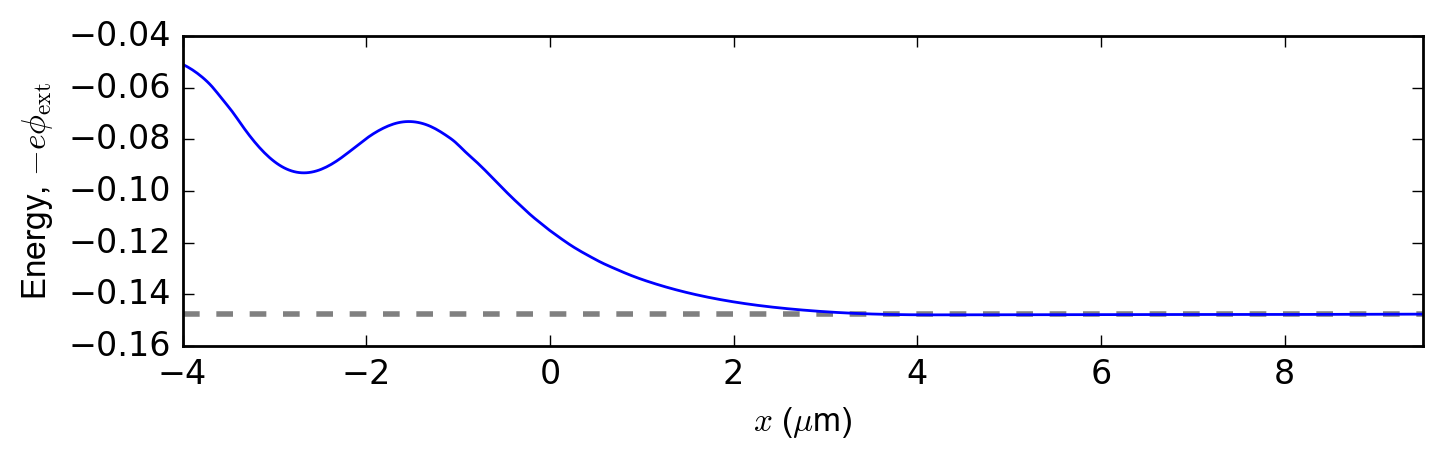

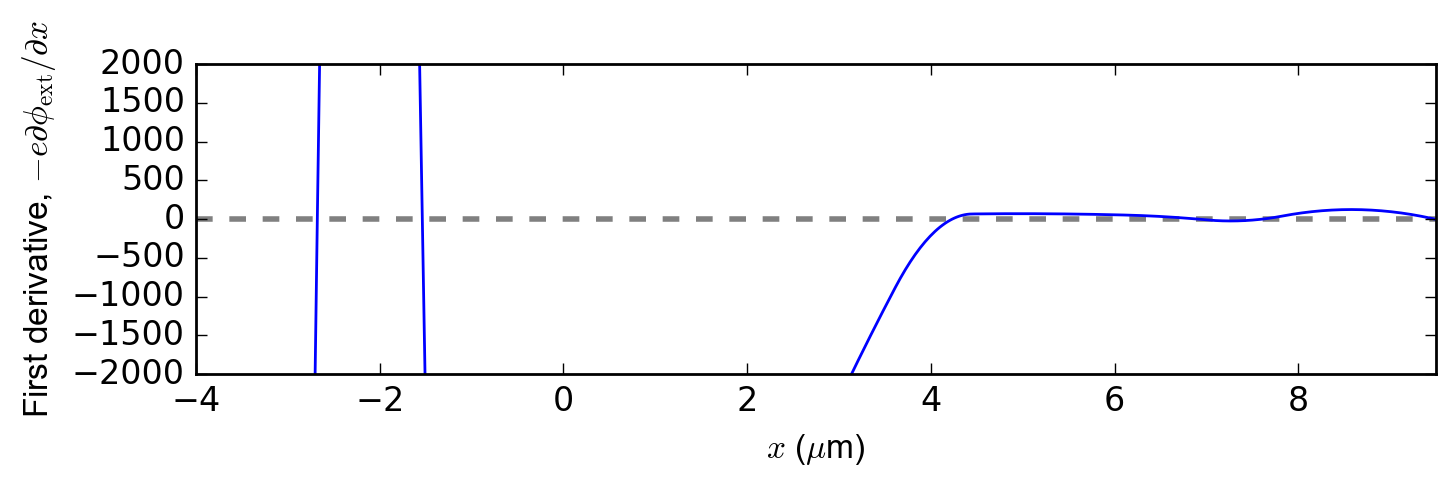

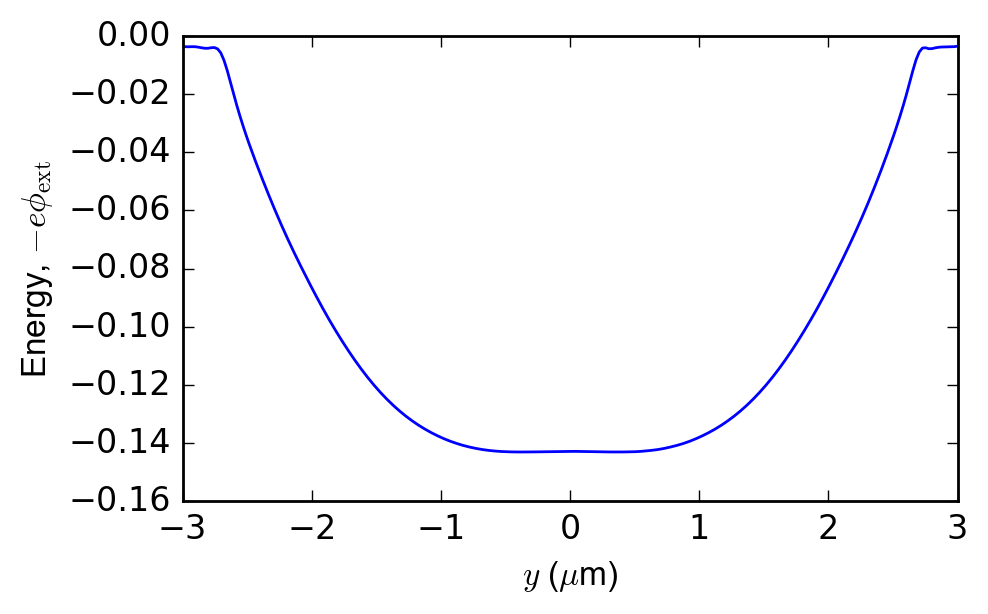

In [86]:
plt.figure(figsize=(8.,2.))
plt.plot(xeval, EP.V(xeval*1E-6, 0E-6))
plt.xlim(np.min(xeval), np.max(xeval))
plt.hlines(EP.V(xeval*1E-6, 0E-6)[-1], np.min(xeval), np.max(xeval), linestyles='--', color='gray', lw=2.0)
plt.xlabel("$x$ ($\mu$m)")
plt.ylabel("Energy, $-e\phi_\mathrm{ext}$")

plt.figure(figsize=(8.,2.))
plt.plot(xeval, EP.dVdx(xeval*1E-6, 0E-6))
plt.xlim(np.min(xeval), np.max(xeval))
plt.hlines(EP.V(xeval*1E-6, 0E-6)[-1], np.min(xeval), np.max(xeval), linestyles='--', color='gray', lw=2.0)
plt.xlabel("$x$ ($\mu$m)")
plt.ylabel("First derivative, $-e\partial\phi_\mathrm{ext}/\partial x$")
plt.ylim(-2E3, 2E3)

plt.figure(figsize=(5.,3.))
plt.plot(yeval, EP.V(2E-6, yeval*1E-6))
plt.xlim(np.min(yeval), np.max(yeval))
plt.xlabel("$y$ ($\mu$m)")
plt.ylabel("Energy, $-e\phi_\mathrm{ext}$")

# Mapping back into the domain 

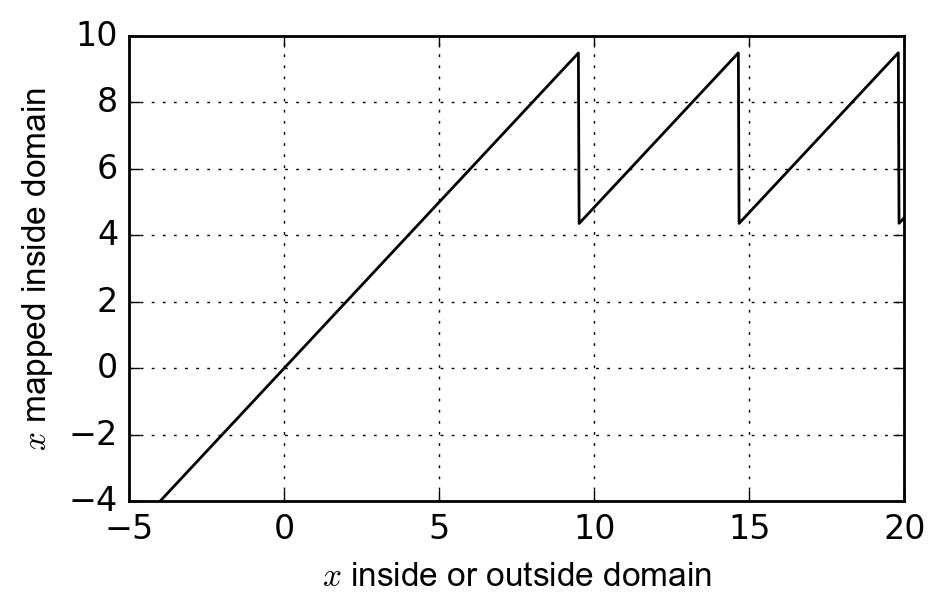

In [87]:
xtest = np.linspace(-4E-6, 20E-6, 1001)

def map_x_into_domain(x, resonator_bounds=None):
    mapped_x = x
    mapped_x[x>resonator_bounds[1]] = resonator_bounds[0] + (x[x>resonator_bounds[1]] - resonator_bounds[0]) \
    % (resonator_bounds[1] - resonator_bounds[0]) 
    return mapped_x

plt.figure(figsize=(5.,3.))
plt.plot(xtest*1E6, EP.map_x_into_domain(xtest, resonator_bounds=(res_left_x*1E-6, res_right_x*1E-6))*1E6, '-k')
plt.xlabel("$x$ inside or outside domain")
plt.ylabel("$x$ mapped inside domain")
plt.grid()

# Checks and timing

In [11]:
%timeit EP.Velectrostatic(np.array([-2.7E-6, -2.7E-6, -2.7E-6]), np.array([-0.5E-6, 0, 0.5E-6]))

The slowest run took 6.31 times longer than the fastest. This could mean that an intermediate result is being cached.
10000 loops, best of 3: 21.5 µs per loop


# Initial condition

In [108]:
N_electrons = 40

# Rectangle
N_cols = 8
N_rows = 5
if N_cols*N_rows != N_electrons:
    raise ValueError("N_cols and N_rows are not compatible with N_electrons")
else:
    separation = 200E-9
    x0 = 3.5E-6
    xs = np.linspace(x0, x0+N_cols*separation, N_cols)
    xinit = np.tile(np.array(xs), N_rows)
    ys = np.linspace(-(N_rows-1)/2.*separation, +(N_rows-1)/2.*separation, N_rows)
    yinit = np.repeat(ys, N_cols)

electron_initial_positions = anneal.xy2r(xinit, yinit)

# Minimization

0	Uopt: -4.83560812 eV	Norm of gradient: 2.10e+04 eV/m
1	Uopt: -5.07276048 eV	Norm of gradient: 2.77e+04 eV/m
2	Uopt: -5.14677188 eV	Norm of gradient: 2.29e+04 eV/m
3	Uopt: -5.17868668 eV	Norm of gradient: 1.50e+04 eV/m
4	Uopt: -5.19504315 eV	Norm of gradient: 1.65e+04 eV/m
5	Uopt: -5.21276705 eV	Norm of gradient: 1.52e+04 eV/m
6	Uopt: -5.22122816 eV	Norm of gradient: 2.41e+04 eV/m
7	Uopt: -5.22297296 eV	Norm of gradient: 1.97e+04 eV/m
8	Uopt: -5.22983481 eV	Norm of gradient: 6.19e+03 eV/m
9	Uopt: -5.23742146 eV	Norm of gradient: 1.99e+04 eV/m
10	Uopt: -5.24020077 eV	Norm of gradient: 1.62e+04 eV/m
         Current function value: -5.240201
         Iterations: 11
         Function evaluations: 12310
         Gradient evaluations: 150


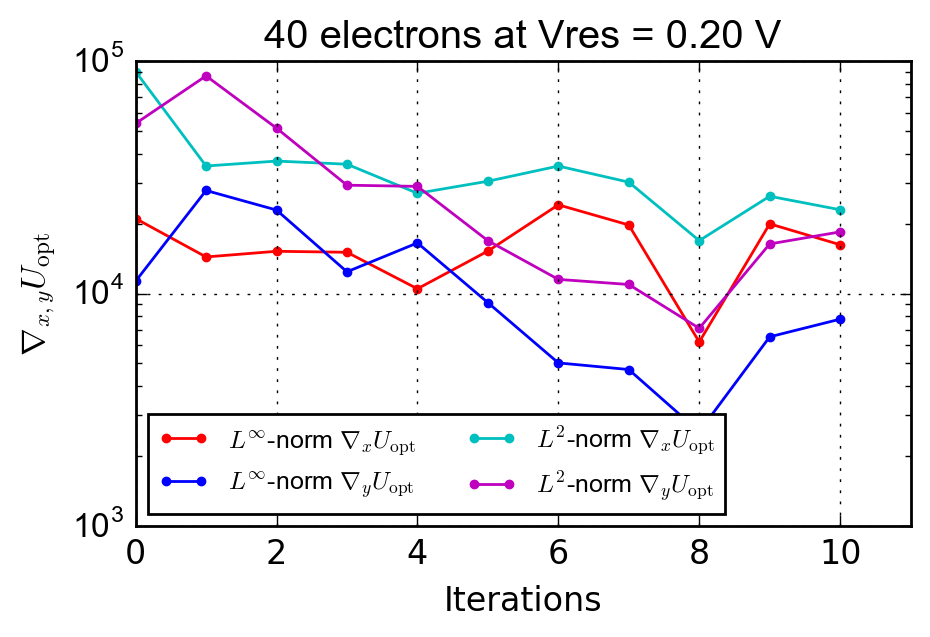

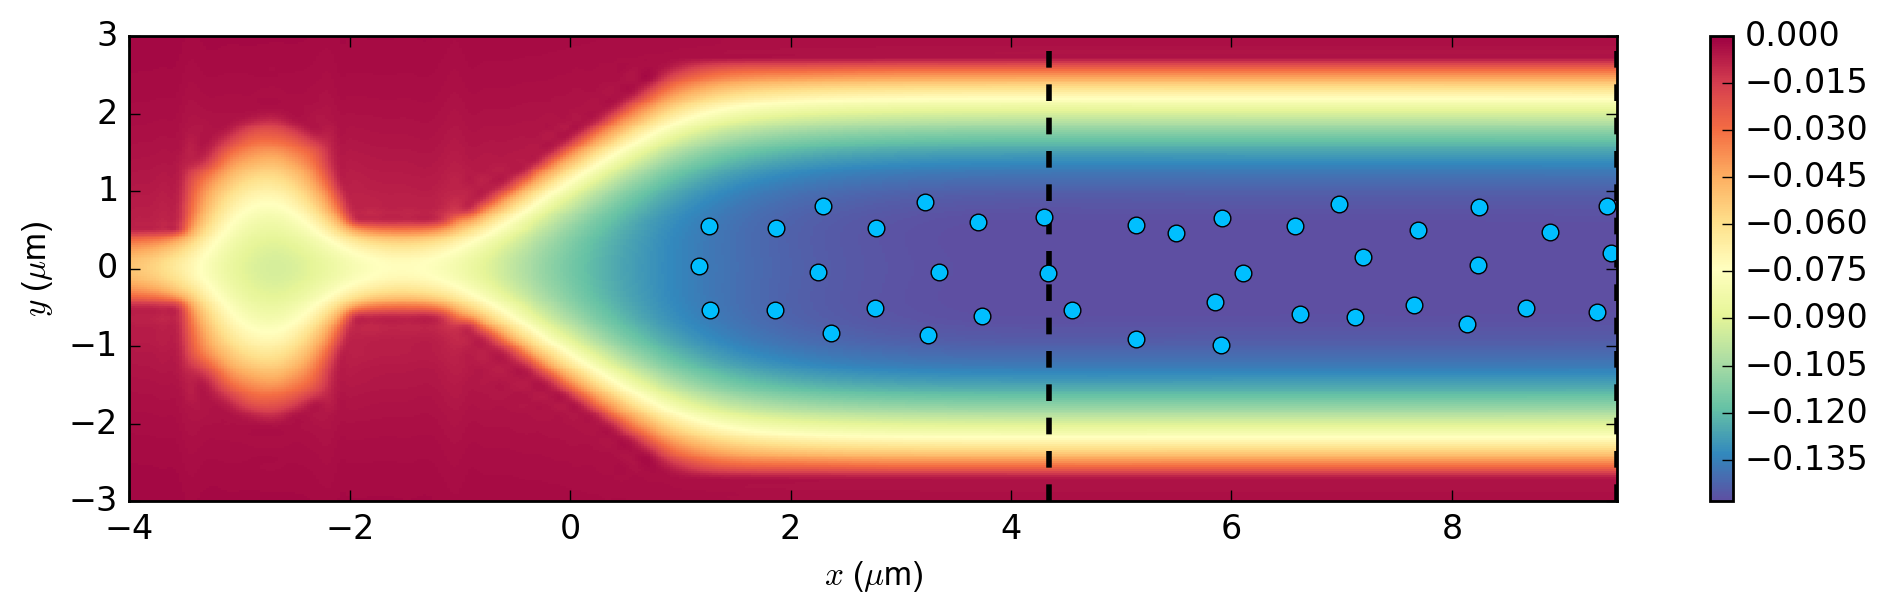

In [111]:
epsilon = 1e-12
use_gradient = False
annealing_steps = []
simulation_name = "%d_electrons_test"%N_electrons
save_path = r"/Users/gkoolstra/Desktop/Electron optimization/Realistic potential/Perturbing"
sub_dir = time.strftime("%H%M%S_{}".format(simulation_name))
save = False
num_trapped_electrons = list()

if use_gradient: 
    jac=EP.grad_total
    ConvMonGradient = EP.grad_total
else:
    jac = None
    ConvMonGradient = lambda x: scipy.optimize.approx_fprime(x, EP.Vtotal, epsilon=epsilon)

if save: 
    os.mkdir(os.path.join(save_path, sub_dir))
    time.sleep(1)
    os.mkdir(os.path.join(save_path, sub_dir, "Figures"))
    os.mkdir(os.path.join(save_path, sub_dir, "Movie"))
    os.mkdir(os.path.join(save_path, sub_dir, "Data"))
    
    time.sleep(1)

conv_mon_save_path = os.path.join(save_path, sub_dir, "Figures")

ConvMon = anneal.ConvergenceMonitor(Uopt=EP.Vtotal, grad_Uopt=ConvMonGradient, N=1, 
                                    Uext=EP.V, 
                                    xext=xeval*1E-6, yext=yeval*1E-6, verbose=True, eps=epsilon, 
                                    save_path=conv_mon_save_path)
ConvMon.figsize = (8.,2.)

res = minimize(EP.Vtotal, electron_initial_positions, method='CG', 
               jac=jac, 
               options={'eps' : epsilon, 'disp': True, 'gtol' : 1E1}, 
               callback=ConvMon.monitor_convergence)

x, y = anneal.r2xy(res['x'])
final_func_val = res['fun']
n_iterations = res['nit']

%matplotlib inline
if len(np.shape(ConvMon.jac))>1:
    figgy = plt.figure(figsize=(5.,3.))
    common.configure_axes(12)
    # LInf-norm
    plt.plot(ConvMon.iter, np.amax(np.abs(ConvMon.jac[:,::2]), axis=1), 
             '.-r', label=r'$L^\infty$-norm $\nabla_x U_\mathrm{opt}$')
    plt.plot(ConvMon.iter, np.amax(np.abs(ConvMon.jac[:,1::2]), axis=1), 
             '.-b', label=r'$L^\infty$-norm $\nabla_y U_\mathrm{opt}$')
    # L2-norm
    plt.plot(ConvMon.iter, np.sum(np.abs(ConvMon.jac[:,::2])**2.0, axis=1)**(1/2.), 
             '.-c', label=r'$L^2$-norm $\nabla_x U_\mathrm{opt}$')
    plt.plot(ConvMon.iter, np.sum(np.abs(ConvMon.jac[:,1::2])**2.0, axis=1)**(1/2.), 
             '.-m', label=r'$L^2$-norm $\nabla_y U_\mathrm{opt}$')

    plt.title("%d electrons at Vres = %.2f V"%(N_electrons, Vres))
        
    plt.xlabel("Iterations")
    plt.ylabel(r"$\nabla_{x,y} U_\mathrm{opt}$")
    plt.yscale('log')
    plt.xlim(0, res['nit'])
    plt.grid()
    plt.legend(loc=0, ncol=2, prop = {'size' : 9})

#Perturb the system to see if we got the global minimum.
perturbed_positions = np.zeros(len(electron_initial_positions))
x_a, y_a = anneal.r2xy(res['x'])    

# Restart convergence monitor
ConvMon.call_counter = 0

for A, T in enumerate(annealing_steps):    
    cprint("Perturbing final state at T = %.2e K"%(T), 'blue')
    
    perturbed_x = x_a + thermal_kick_x(x_a, y_a, T) * np.random.rand(len(x))
    perturbed_y = y_a + thermal_kick_y(x_a, y_a, T) * np.random.rand(len(y))

    perturbed_positions[::2] = perturbed_x
    perturbed_positions[1::2] = perturbed_y

    res = minimize(EP.Vtotal, perturbed_positions, method='CG', 
                   jac=jac, 
                   options={'disp': False, 'gtol' : 1E-1}, 
                   callback=ConvMon.monitor_convergence)
    
    PP = anneal.PostProcess(save_path=os.path.join(save_path, sub_dir, "Figures"))
    num_trapped_electrons.append(PP.get_trapped_electrons(res['x']))

    if res['fun'] < final_func_val and res['status'] == 0:
        final_func_val = res['fun']
        x_pre_anneal, y_pre_anneal = anneal.r2xy(res['x'])
        jac_pre_anneal = np.amax(np.abs(res['jac']))

    elif res['fun'] < final_func_val and res['status'] > 0:
        cprint("There is a lower energy state, but the minimizer did not converge", "red")

        figgy = plt.figure(figsize=(5.,3.))
        common.configure_axes(12)
        # LInf-norm
        plt.plot(ConvMon.iter, np.amax(np.abs(ConvMon.jac[:,::2]), axis=1), 
                 '.-r', label=r'$L^\infty$-norm $\nabla_x U_\mathrm{opt}$')
        plt.plot(ConvMon.iter, np.amax(np.abs(ConvMon.jac[:,1::2]), axis=1), 
                 '.-b', label=r'$L^\infty$-norm $\nabla_y U_\mathrm{opt}$')
        # L2-norm
        plt.plot(ConvMon.iter, np.sum(np.abs(ConvMon.jac[:,::2])**2.0, axis=1)**(1/2.), 
                 '.-c', label=r'$L^2$-norm $\nabla_x U_\mathrm{opt}$')
        plt.plot(ConvMon.iter, np.sum(np.abs(ConvMon.jac[:,1::2])**2.0, axis=1)**(1/2.), 
                 '.-m', label=r'$L^2$-norm $\nabla_y U_\mathrm{opt}$')

        plt.title("%d electrons at Vres = %.2f V"%(N_electrons, Vres))

        plt.xlabel("Iterations")
        plt.ylabel(r"$\nabla_{x,y} U_\mathrm{opt}$")
        plt.yscale('log')
        plt.xlim(0, res['nit'])
        plt.grid()
        plt.legend(loc=0, ncol=2, prop = {'size' : 9})

    elif res['fun'] >= final_func_val and res['status'] > 0:
        cprint("Minimizer did not converge, but this is not the lowest energy state", "magenta")

if save: 
    # Create a movie
    ConvMon.create_movie(fps=10, 
                         filenames_in="%05d.png", 
                         filename_out="%d_electrons_4K_anneal.mp4"%(N_electrons))

    # Move the file from the Figures folder to the Movie folder
    os.rename(os.path.join(save_path, sub_dir, 
                           "Figures/%d_electrons_4K_anneal.mp4"%(N_electrons)),
              os.path.join(save_path, sub_dir, 
                           "Movie/%d_electrons_4K_anneal.mp4"%(N_electrons)))

#cprint("After perturbation, minimum function value obtained: %.8f eV with gradient %.4f eV/m"\
#       %(final_func_val, jac_pre_anneal), "green")
            
#x_a, y_a = x_pre_anneal, y_pre_anneal

# Highest gradients: 
#largest_xs = np.argsort(ConvMon.jac[-1,::2])[-10:]
#largest_ys = np.argsort(ConvMon.jac[-1,1::2])[-10:]

# Compare state before and after annealing: 
Xeval, Yeval = np.meshgrid(xeval, yeval)
figgy = plt.figure(figsize=(12,3))
common.configure_axes(12)
plt.pcolormesh(xeval, yeval, EP.V(Xeval*1E-6, Yeval*1E-6), cmap=plt.cm.Spectral_r, vmax=0.0)
plt.plot(x*1E6, y*1E6, 'o', color='deepskyblue')
#plt.plot(x_a*1E6, y_a*1E6, 'o', color='deeppink')
#plt.plot(xinit*1E6, yinit*1E6, 'o', color='palegreen', alpha=0.5)
plt.vlines(EP.res_right_x*1E6, -3.0, 3.0, linestyles='--', color='k', lw=2.0)
plt.vlines(EP.res_left_x*1E6, -3.0, 3.0, linestyles='--', color='k', lw=2.0)
plt.xlim(np.min(xeval), np.max(xeval))
plt.ylim(np.min(yeval), np.max(yeval))
plt.xlabel("$x$ ($\mu$m)")
plt.ylabel("$y$ ($\mu$m)")
plt.colorbar()

#plt.plot(x[largest_xs]*1E6, y[largest_xs]*1E6, 'o', color='red')
#plt.plot(x[largest_ys]*1E6, y[largest_ys]*1E6, 'o', color='darkorange')


# # Plot number of trapped electrons
# plt.figure(figsize=(5.,3.))
# common.configure_axes(12)
# plt.plot(num_trapped_electrons, 'o', color='deeppink')
# plt.xlabel("Iteration")
# plt.ylabel("Number of trapped electrons")

In [75]:
ConvMon.jac[:,0]

array([ 18813.04776088,  20786.69874438,   6035.24646091,  -6077.68994878,
          966.01143011,  -4920.96507084])

In [ ]:
x[0]